# Import Library & Dataset

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path


metadata_path = Path("/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data/dataset_splits_with_metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,name,label,source,split
0,NORMAL2-IM-0465-0001.jpeg,NORMAL,oct,val
1,IM-0374-0001.jpeg,NORMAL,oct,val
2,IM-0626-0001-0001.jpeg,NORMAL,oct,val
3,NORMAL2-IM-0338-0001.jpeg,NORMAL,oct,val
4,NORMAL2-IM-0944-0001.jpeg,NORMAL,oct,val


# Exploratory Data Analysis (EDA) 

### Class Distribution

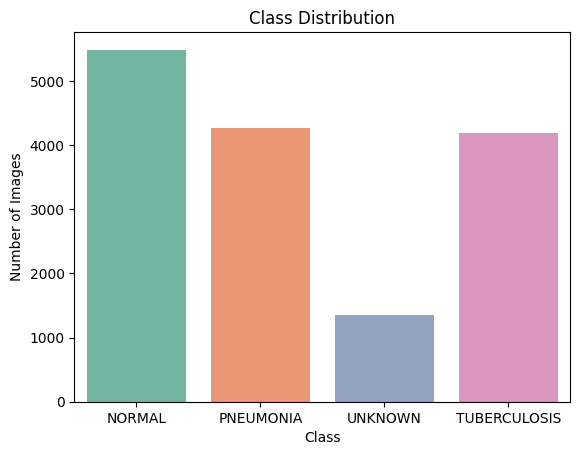

In [2]:
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


### Data Split Distribution

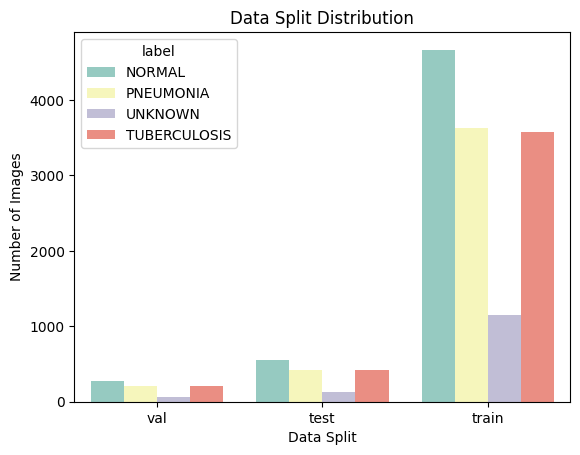

In [3]:
sns.countplot(data=df, x='split', hue='label', palette='Set3')
plt.title('Data Split Distribution')
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.show()

### Image Dimension Distribution by Split

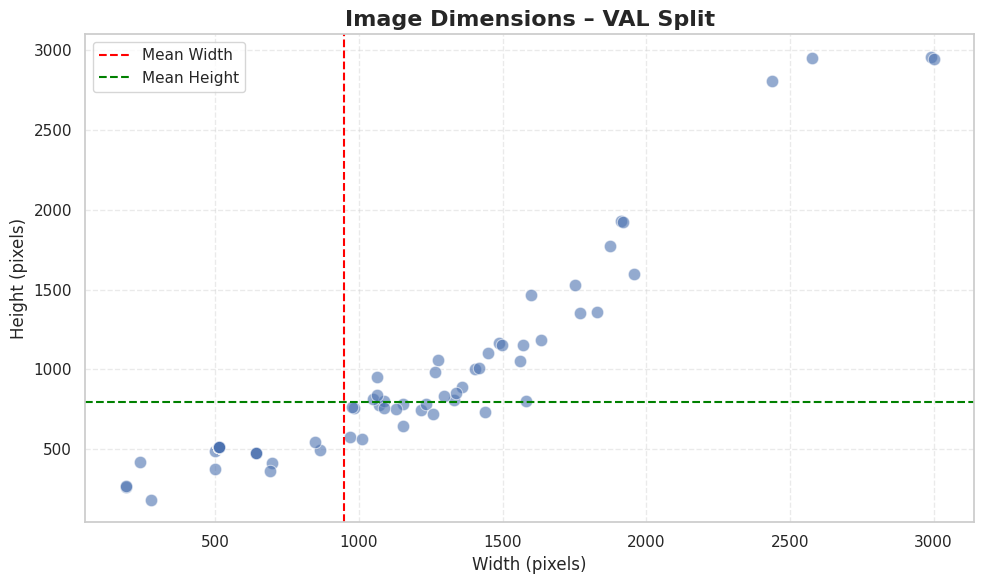

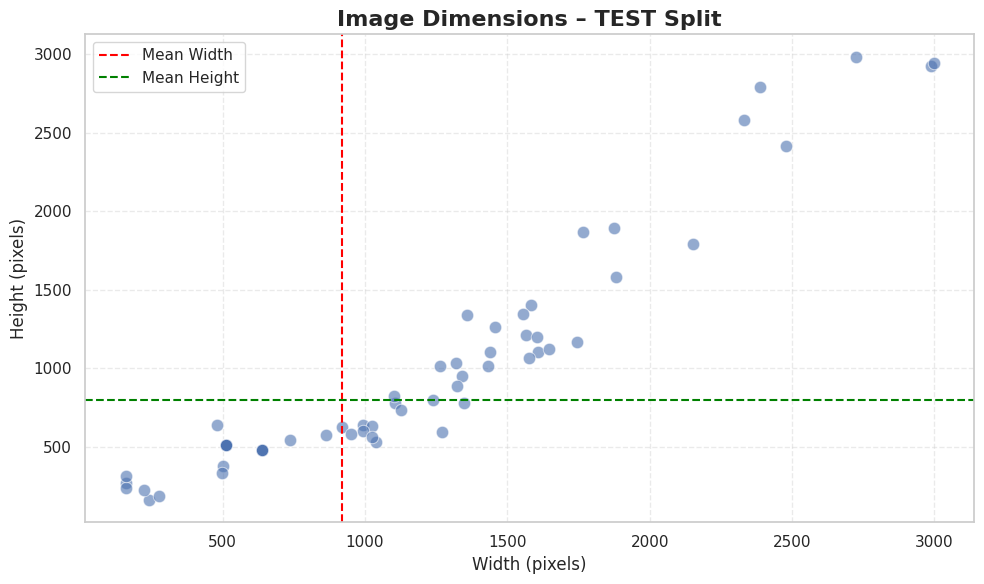

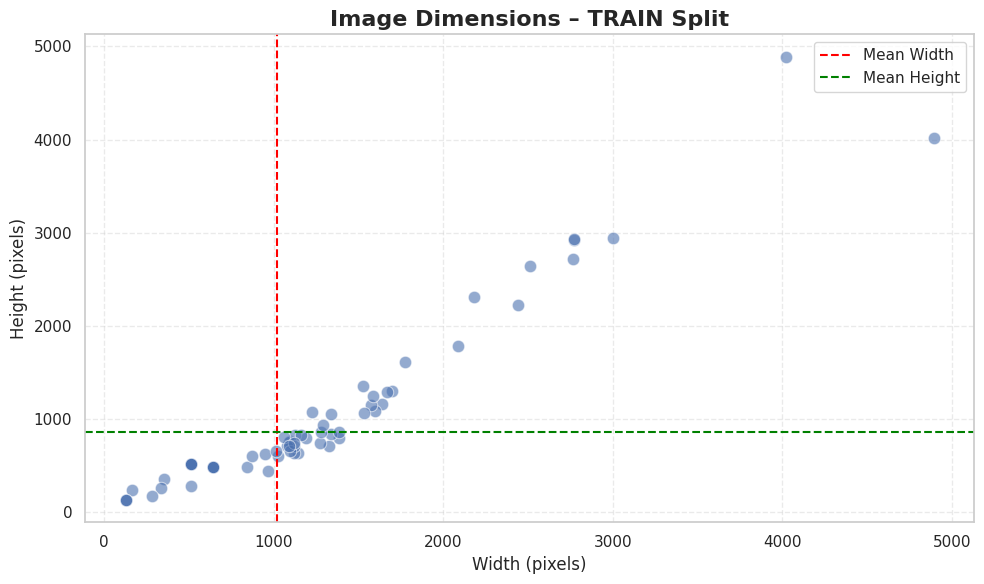

In [4]:
# Store data for each split
split_dimension_data = []

# Loop through each split
for split_name in df['split'].unique():
    # Sample 100 (or fewer if not enough) from the current split
    sample_subset = df[df['split'] == split_name].sample(n=min(100, len(df[df['split'] == split_name])), random_state=42)

    for _, row in sample_subset.iterrows():
        image_path = Path(f"/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data/{row['split']}/{row['label']}/{row['name']}")
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                split_dimension_data.append({
                    'Split': split_name,
                    'Width': width,
                    'Height': height
                })
        except Exception as e:
            print(f"Error opening {image_path}: {e}")

# Create DataFrame
dim_df = pd.DataFrame(split_dimension_data)

# Plot each split separately
sns.set(style="whitegrid")
for split in dim_df['Split'].unique():
    subset = dim_df[dim_df['Split'] == split]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=subset, x='Width', y='Height', s=80, alpha=0.6, edgecolor='w', color='#4C72B0')

    # Mean lines
    plt.axvline(subset['Width'].mean(), color='red', linestyle='--', label='Mean Width')
    plt.axhline(subset['Height'].mean(), color='green', linestyle='--', label='Mean Height')
    plt.legend()

    # Titles
    plt.title(f'Image Dimensions – {split.upper()} Split', fontsize=16, fontweight='bold')
    plt.xlabel('Width (pixels)', fontsize=12)
    plt.ylabel('Height (pixels)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

### Sample Images per Class

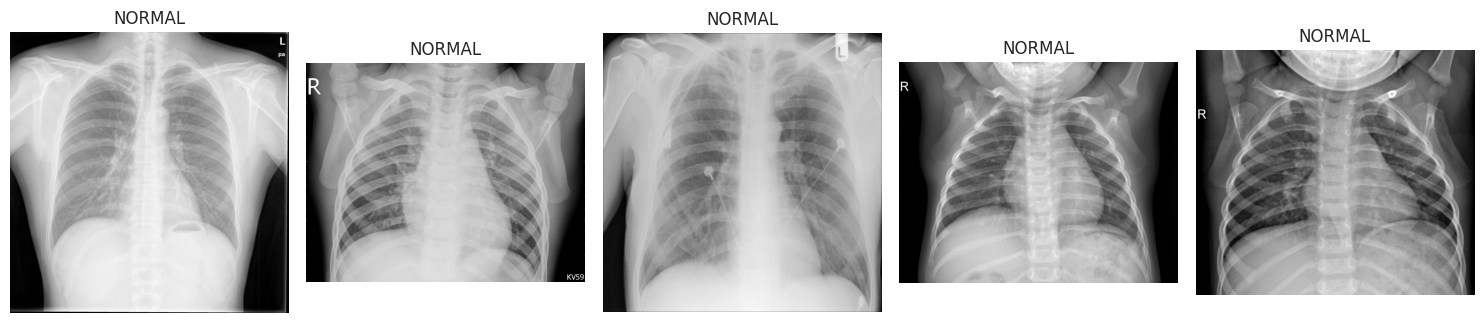

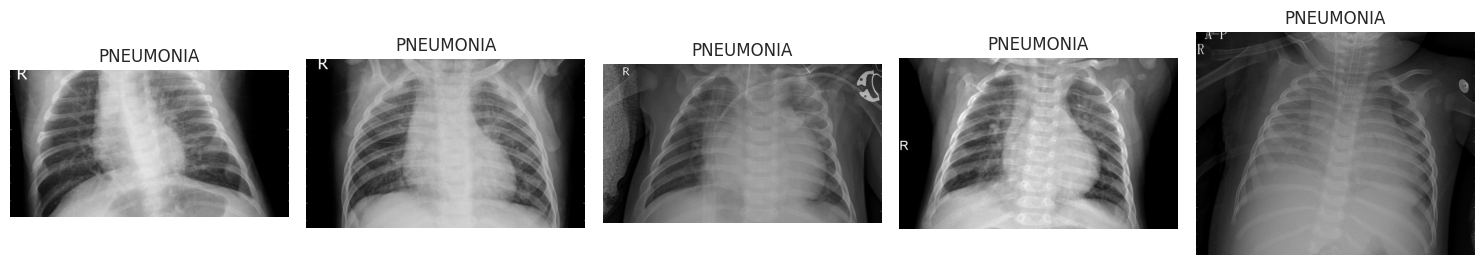

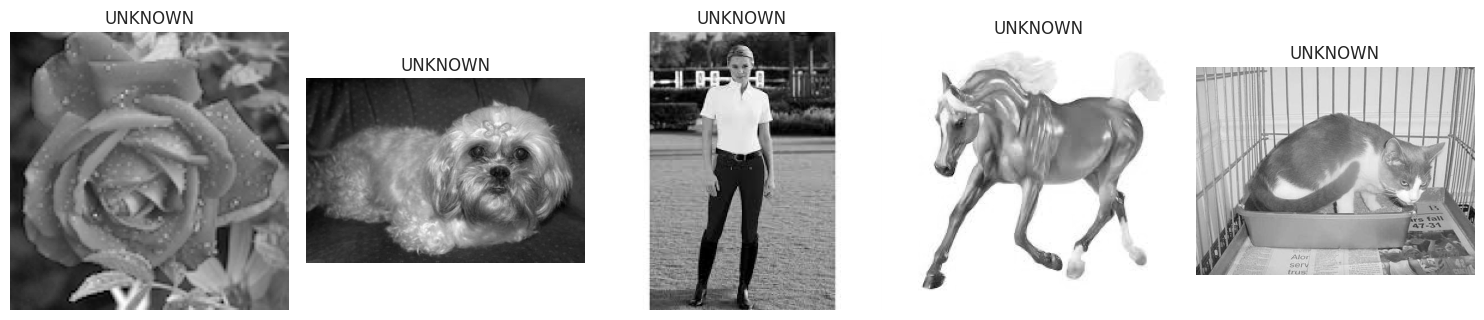

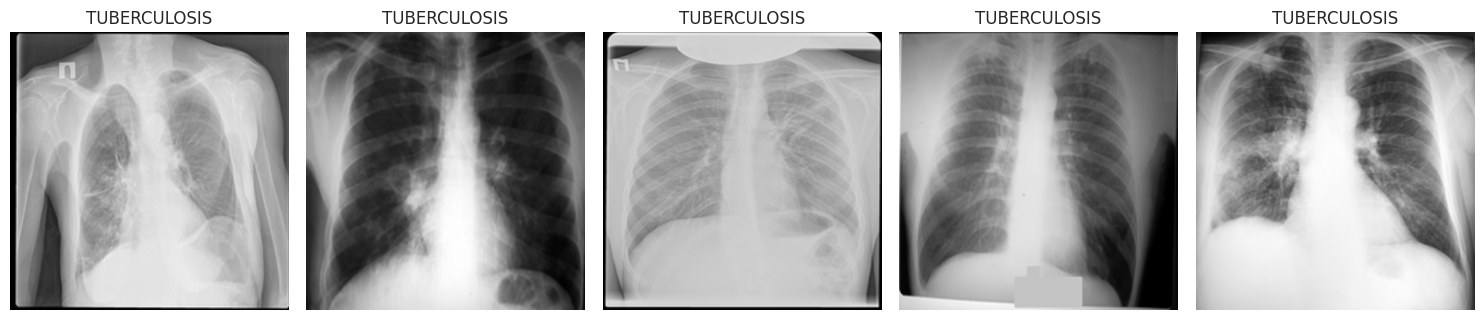

In [ ]:
import random

def show_sample_images(df, label, split='train', num_samples=5):
    # Filter by split and label
    sample_paths = df[(df['label'] == label) & (df['split'] == split)].sample(num_samples, random_state=42)['name']
    
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(sample_paths):
        image_path = Path(f"/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data/{split}/{label}/{image_name}")
        try:
            with Image.open(image_path) as img:
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img.convert('L'), cmap='gray')
                plt.title(f'{label}')
                plt.axis('off')
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
    plt.tight_layout()
    plt.show()

# Show samples from each class
for label in df['label'].unique():
    show_sample_images(df, label, split='train', num_samples=5)


# Data Preprocessing

### Check for Missing and Duplicate Values

In [7]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Check and remove duplicate rows
initial_len = len(df)
df = df.drop_duplicates(subset=['name']).reset_index(drop=True)
print(f"Removed {initial_len - len(df)} duplicate metadata rows.")


Missing values per column:
 name      0
label     0
source    0
split     0
dtype: int64
Removed 0 duplicate metadata rows.


### Remove Variable

In [4]:
# Remove UNKNOWN label
df = df[df['label'] != 'UNKNOWN'].reset_index(drop=True)
print("Remaining labels:", df['label'].unique())

Remaining labels: ['NORMAL' 'PNEUMONIA' 'TUBERCULOSIS']


### Create Image Path

In [5]:
# Create full image paths
df['image_path'] = df.apply(
    lambda row: str(Path(f"/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data/{row['split']}/{row['label']}/{row['name']}")),
    axis=1
)

### Split Dataset

In [6]:
# Split the data
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']

### Data Preprocessing

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.03,
    height_shift_range=0.03,
    fill_mode='nearest'
)


# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 11873 validated image filenames belonging to 3 classes.
Found 694 validated image filenames belonging to 3 classes.
Found 1392 validated image filenames belonging to 3 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = {'NORMAL': 0, 'PNEUMONIA': 1, 'TUBERCULOSIS': 2}
train_df['label_idx'] = train_df['label'].map(class_indices)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_idx']),
    y=train_df['label_idx']
)

# Convert to dictionary
class_weights = dict(enumerate(class_weights_array))

print("Class Weights:", class_weights)


Class Weights: {0: 0.8480108563674024, 1: 1.0893659968804477, 2: 1.1076592965761731}


/tmp/ipykernel_35/2347368842.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label_idx'] = train_df['label'].map(class_indices)


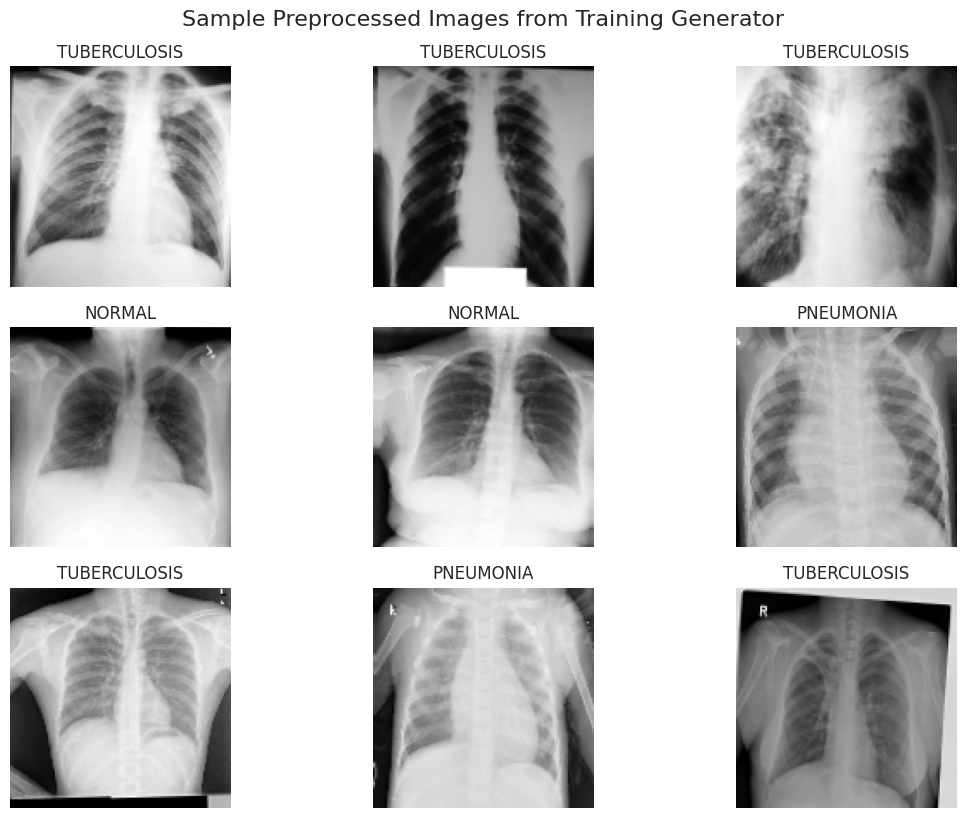

In [ ]:
# Get one batch from the generator
images, labels = next(train_gen)

# Convert one-hot labels back to class names
class_indices = train_gen.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Show first 9 images in the batch
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Remove channel dim since grayscale is (128, 128, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    class_label = index_to_class[np.argmax(labels[i])]
    plt.title(class_label)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Preprocessed Images from Training Generator", fontsize=16, y=1.02)
plt.show()


# Model Building (CNN)

### CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


base_cnn = Sequential([
    Input(shape=(128, 128, 1)),                     
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')                  
])

base_cnn.compile(optimizer=Adam(0.0005), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

history_cnn = base_cnn.fit(train_gen, 
                           validation_data=val_gen, 
                           epochs=15, 
                           class_weight=class_weights)

base_cnn.summary()

I0000 00:00:1747213994.491502      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747213994.492294      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1747214001.365205     101 service.cc:148] XLA service 0x7e61380084c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747214001.366833     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747214001.366860     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747214001.753274     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/372 ━━━━━━━━━━━━━━━━━━━━ 49:03 8s/step - accuracy: 0.1875 - loss: 1.1768

I0000 00:00:1747214006.154863     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


372/372 ━━━━━━━━━━━━━━━━━━━━ 320s 842ms/step - accuracy: 0.6789 - loss: 0.6832 - val_accuracy: 0.8660 - val_loss: 0.3002
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 170s 457ms/step - accuracy: 0.8675 - loss: 0.3187 - val_accuracy: 0.9020 - val_loss: 0.2174
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 168s 452ms/step - accuracy: 0.8975 - loss: 0.2489 - val_accuracy: 0.9107 - val_loss: 0.2179
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 172s 461ms/step - accuracy: 0.9142 - loss: 0.2078 - val_accuracy: 0.9323 - val_loss: 0.1571
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 176s 474ms/step - accuracy: 0.9272 - loss: 0.1779 - val_accuracy: 0.9467 - val_loss: 0.1330
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 188s 504ms/step - accuracy: 0.9278 - loss: 0.1692 - val_accuracy: 0.9366 - val_loss: 0.1298
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 185s 498ms/step - accuracy: 0.9376 - loss: 0.1536 - val_accuracy: 0.9323 - val_loss: 0.1567
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 169s 455ms/step - accuracy: 0.9382 - loss: 0.14

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,913,355 (37.82 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,608,904 (25.21 MB)

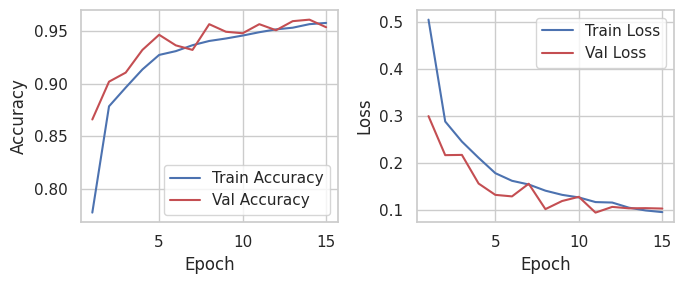

In [14]:
acc2 = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss2 = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1,len(acc2)+1)
 
#creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
 
axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs,loss2,'b',label="Train Loss")
axes[1].plot(epochs,val_loss, 'r',label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
#adjusting layout for better spacing
plt.tight_layout()
 
#display the figure
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 862ms/step - accuracy: 0.9640 - loss: 0.0985
CNN Test Accuracy: 0.9626
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step
Classification Report (CNN):
              precision    recall  f1-score   support

      NORMAL       0.94      0.96      0.95       548
   PNEUMONIA       0.98      0.96      0.97       427
TUBERCULOSIS       0.97      0.97      0.97       417

    accuracy                           0.96      1392
   macro avg       0.96      0.96      0.96      1392
weighted avg       0.96      0.96      0.96      1392



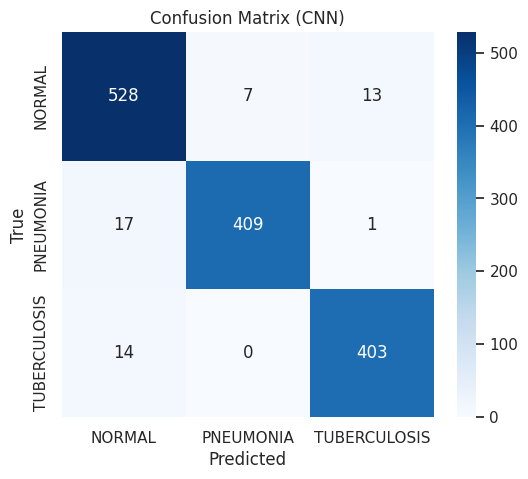

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate CNN
test_loss_cnn, test_acc_cnn = base_cnn.evaluate(test_gen)
print(f"CNN Test Accuracy: {test_acc_cnn:.4f}")

y_true = test_gen.classes
y_pred_cnn = np.argmax(base_cnn.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("Classification Report (CNN):")
print(classification_report(y_true, y_pred_cnn, target_names=class_labels))

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Hyperparameter Tuning (CNN)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
import keras_tuner as kt

class CustomTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        kwargs['batch_size'] = hp.get('batch_size')  
        return super().run_trial(trial, *args, **kwargs)

def build_tuned_cnn(hp):
    hp.Choice('batch_size', [32, 64, 128])
    model = Sequential()
    model.add(Input(shape=(128, 128, 1)))

    # Conv Layer 1
    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', [32, 64]),kernel_size=3,activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # Conv Layer 2
    model.add(Conv2D(
        filters=hp.Choice('conv2_filters', [64, 128]),kernel_size=3,activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # Conv Layer 3
    model.add(Conv2D(
        filters=hp.Choice('conv3_filters', [128, 256]),kernel_size=3,activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # Flatten + Dense
    model.add(Flatten())
    model.add(Dense(units=hp.Choice('dense_units', [128, 256]),activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.4, step=0.1)))
    model.add(Dense(3, activation='softmax'))

    # Optimizer setup
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')  # smaller range

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

    return model


In [18]:
# ─── Setup Keras Tuner
cnn_tuner = CustomTuner(
    hypermodel=build_tuned_cnn,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='cnn_tuning_dir',
    project_name='cnn_tuning',
    overwrite=True
)

cnn_tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
)

Trial 8 Complete [00h 28m 41s]
val_accuracy: 0.9567723274230957

Best val_accuracy So Far: 0.9582132697105408
Total elapsed time: 03h 51m 28s


In [20]:
# Get all trials (using get_best_trials with max_trials)
all_trials = cnn_tuner.oracle.get_best_trials(num_trials=8)

# Sort trials by score (descending)
sorted_trials = sorted(all_trials, key=lambda t: t.score, reverse=True)

# Print out results for each trial
print("\nAll Trial Results (Sorted by Validation Accuracy):\n")
for i, trial in enumerate(sorted_trials, start=1):
    print(f"Trial {i} (val_accuracy: {trial.score:.4f})")
    for param, value in trial.hyperparameters.values.items():
        print(f"  - {param}: {value}")
    print("-" * 40)



All Trial Results (Sorted by Validation Accuracy):

Trial 1 (val_accuracy: 0.9582)
  - batch_size: 128
  - conv1_filters: 32
  - conv2_filters: 64
  - conv3_filters: 128
  - dense_units: 256
  - dropout: 0.30000000000000004
  - optimizer: rmsprop
  - learning_rate: 0.0002824952294528987
----------------------------------------
Trial 2 (val_accuracy: 0.9568)
  - batch_size: 64
  - conv1_filters: 64
  - conv2_filters: 128
  - conv3_filters: 256
  - dense_units: 256
  - dropout: 0.4
  - optimizer: rmsprop
  - learning_rate: 0.0003586977467212148
----------------------------------------
Trial 3 (val_accuracy: 0.9568)
  - batch_size: 32
  - conv1_filters: 32
  - conv2_filters: 128
  - conv3_filters: 256
  - dense_units: 256
  - dropout: 0.4
  - optimizer: rmsprop
  - learning_rate: 0.0007618477324631783
----------------------------------------
Trial 4 (val_accuracy: 0.9539)
  - batch_size: 32
  - conv1_filters: 32
  - conv2_filters: 128
  - conv3_filters: 128
  - dense_units: 256
  - dropo

In [23]:
# Retrieve Best Hyperparameter
best_hps = cnn_tuner.get_best_hyperparameters(1)[0]

print("\nBest Hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

best_cnn_model = build_tuned_cnn(best_hps)
batch_size = best_hps.get('batch_size')

# Retrain from Scratch 
history_tuned_cnn = best_cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
)


Best Hyperparameters:
batch_size: 128
conv1_filters: 32
conv2_filters: 64
conv3_filters: 128
dense_units: 256
dropout: 0.30000000000000004
optimizer: rmsprop
learning_rate: 0.0002824952294528987
Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 178s 469ms/step - accuracy: 0.6254 - loss: 0.7670 - val_accuracy: 0.8516 - val_loss: 0.3586 - learning_rate: 2.8250e-04
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 179s 481ms/step - accuracy: 0.8433 - loss: 0.3711 - val_accuracy: 0.8991 - val_loss: 0.2601 - learning_rate: 2.8250e-04
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 185s 497ms/step - accuracy: 0.8846 - loss: 0.2848 - val_accuracy: 0.9049 - val_loss: 0.2112 - learning_rate: 2.8250e-04
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 178s 479ms/step - accuracy: 0.8986 - loss: 0.2477 - val_accuracy: 0.9063 - val_loss: 0.1959 - learning_rate: 2.8250e-04
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 168s 451ms/step - accuracy: 0.9153 - loss: 0.2010 - val_accuracy: 0.9265 - val_loss: 0.1621 - learning_rate: 2.8250e-04
Epoc

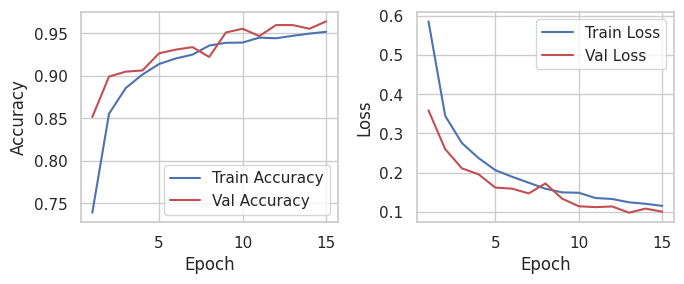

In [24]:
acc2 = history_tuned_cnn.history['accuracy']
val_acc = history_tuned_cnn.history['val_accuracy']
loss2 = history_tuned_cnn.history['loss']
val_loss = history_tuned_cnn.history['val_loss']
epochs = range(1, len(acc2) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 410ms/step - accuracy: 0.9447 - loss: 0.1706
Tuned CNN Test Accuracy: 0.9526
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step
Tuned CNN Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.93      0.94       548
   PNEUMONIA       0.96      0.97      0.97       427
TUBERCULOSIS       0.95      0.95      0.95       417

    accuracy                           0.95      1392
   macro avg       0.95      0.95      0.95      1392
weighted avg       0.95      0.95      0.95      1392



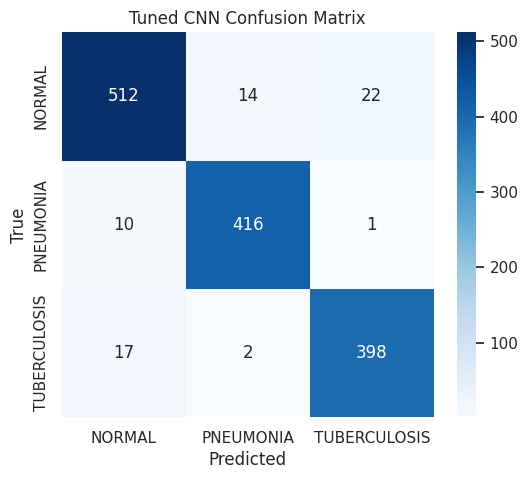

In [ ]:
# Evaluate Tuned CNN
cnn_test_loss, cnn_test_acc = best_cnn_model.evaluate(test_gen)
print(f"Tuned CNN Test Accuracy: {cnn_test_acc:.4f}")

y_true = test_gen.classes
y_pred_cnn = np.argmax(best_cnn_model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("Tuned CNN Classification Report:")
print(classification_report(y_true, y_pred_cnn, target_names=class_labels))

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Tuned CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Model Building (CNN-RNN)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

def build_base_cnn_rnn():
    model = Sequential()
    
    # Input Layer (Grayscale Image)
    model.add(Input(shape=(128, 128, 1)))
    
    # Conv Layers for Feature Extraction
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and reshape for RNN input
    model.add(Flatten())
    model.add(Reshape((1, -1)))  # Reshape for LSTM (timesteps, features)
    
    # LSTM Layer to learn sequential dependencies
    model.add(LSTM(128, activation='relu'))
    
    # Fully Connected Layer for Decision
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer (3 classes)
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

model_cnn_rnn = build_base_cnn_rnn()

history_cnn_rnn = model_cnn_rnn.fit(train_gen, 
                                    validation_data=val_gen, 
                                    epochs=15, 
                                    class_weight=class_weights)

model_cnn_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1747250188.939883     105 service.cc:148] XLA service 0x35b0e340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747250188.940957     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747250188.940977     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747250189.515230     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/372 ━━━━━━━━━━━━━━━━━━━━ 57:36 9s/step - accuracy: 0.4375 - loss: 1.0665

I0000 00:00:1747250193.511156     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


372/372 ━━━━━━━━━━━━━━━━━━━━ 319s 834ms/step - accuracy: 0.6984 - loss: 0.6486 - val_accuracy: 0.9020 - val_loss: 0.2406
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 162s 434ms/step - accuracy: 0.8907 - loss: 0.2694 - val_accuracy: 0.9294 - val_loss: 0.1676
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 161s 433ms/step - accuracy: 0.9226 - loss: 0.1890 - val_accuracy: 0.9467 - val_loss: 0.1381
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 163s 438ms/step - accuracy: 0.9325 - loss: 0.1653 - val_accuracy: 0.9424 - val_loss: 0.1295
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 161s 433ms/step - accuracy: 0.9404 - loss: 0.1461 - val_accuracy: 0.9568 - val_loss: 0.1282
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 160s 431ms/step - accuracy: 0.9525 - loss: 0.1178 - val_accuracy: 0.9597 - val_loss: 0.1008
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 165s 442ms/step - accuracy: 0.9495 - loss: 0.1234 - val_accuracy: 0.9539 - val_loss: 0.1275
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 162s 436ms/step - accuracy: 0.9586 - loss: 0.09

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 32768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │      16,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,909,195 (194.20 MB)

 Trainable params: 16,969,731 (64.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,939,464 (129.47 MB)

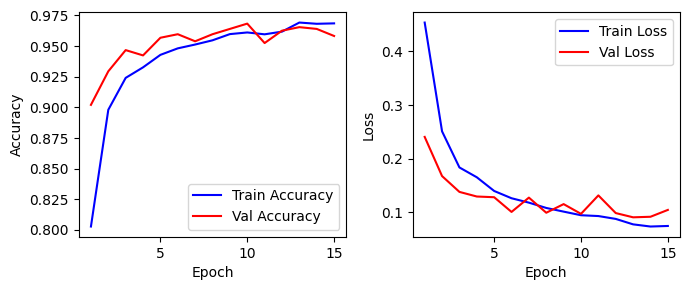

In [14]:
acc2 = history_cnn_rnn.history['accuracy']
val_acc = history_cnn_rnn.history['val_accuracy']
loss2 = history_cnn_rnn.history['loss']
val_loss = history_cnn_rnn.history['val_loss']

epochs = range(1,len(acc2)+1)
 
#creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
 
axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs,loss2,'b',label="Train Loss")
axes[1].plot(epochs,val_loss, 'r',label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
#adjusting layout for better spacing
plt.tight_layout()
 
#display the figure
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9626 - loss: 0.0910
CNN Test Accuracy: 0.9569
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step
Classification Report (CNN_RNN):
              precision    recall  f1-score   support

      NORMAL       0.92      0.97      0.95       548
   PNEUMONIA       0.98      0.97      0.98       427
TUBERCULOSIS       0.99      0.92      0.95       417

    accuracy                           0.96      1392
   macro avg       0.96      0.95      0.96      1392
weighted avg       0.96      0.96      0.96      1392



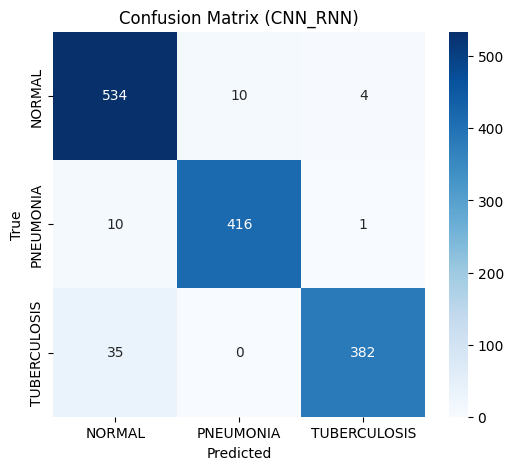

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate CNN
test_loss_cnn_rnn, test_acc_cnn_rnn = model_cnn_rnn.evaluate(test_gen)
print(f"CNN Test Accuracy: {test_acc_cnn_rnn:.4f}")

y_true = test_gen.classes
y_pred_cnn_rnn = np.argmax(model_cnn_rnn.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("Classification Report (CNN_RNN):")
print(classification_report(y_true, y_pred_cnn_rnn, target_names=class_labels))

cm_cnn_rnn = confusion_matrix(y_true, y_pred_cnn_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (CNN_RNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Hyperparamter Tuning (CNN-RNN) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt

class CustomTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        kwargs['batch_size'] = hp.get('batch_size')  
        return super().run_trial(trial, *args, **kwargs)

def build_tuned_cnn_rnn(hp):
    hp.Choice('batch_size', [32, 64, 128])
    
    model = Sequential()
    model.add(Input(shape=(128, 128, 1))) 
    
    model.add(Conv2D(filters=hp.Choice('conv1_filters', [32, 64]),
                     kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Choice('conv2_filters', [64, 128]),
                     kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Choice('conv3_filters', [128, 256]),
                     kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Reshape((1, -1)))  # Reshape to (timesteps, features) for LSTM
    
    model.add(LSTM(units=hp.Int('lstm_units', 64, 256, step=64), activation='relu'))
    
    model.add(Dense(units=hp.Choice('dense_units', [128, 256]), activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.4, step=0.1)))
    model.add(Dense(3, activation='softmax'))  # 3 classes for classification
    
    # Optimizer Setup
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model


In [10]:
# Setup Keras Tuner for Hyperparameter Search 
cnn_rnn_tuner = CustomTuner(
    hypermodel=build_tuned_cnn_rnn,
    objective='val_accuracy',
    max_trials=8,  
    executions_per_trial=1,  
    directory='cnn_rnn_tuning_dir',  
    project_name='cnn_rnn_tuning',  
    overwrite=True  
)

# Run Tuning Search 
cnn_rnn_tuner.search(
    train_gen,  
    validation_data=val_gen,  
    epochs=10,  
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
)


Trial 8 Complete [00h 27m 04s]
val_accuracy: 0.9610950946807861

Best val_accuracy So Far: 0.9654178619384766
Total elapsed time: 03h 40m 38s


In [11]:
# Get all trials (using get_best_trials with max_trials)
all_trials = cnn_rnn_tuner.oracle.get_best_trials(num_trials=8)

# Sort trials by score (descending)
sorted_trials = sorted(all_trials, key=lambda t: t.score, reverse=True)

# Print out results for each trial
print("\nAll Trial Results (Sorted by Validation Accuracy):\n")
for i, trial in enumerate(sorted_trials, start=1):
    print(f"Trial {i} (val_accuracy: {trial.score:.4f})")
    for param, value in trial.hyperparameters.values.items():
        print(f"  - {param}: {value}")
    print("-" * 40)



All Trial Results (Sorted by Validation Accuracy):

Trial 1 (val_accuracy: 0.9654)
  - batch_size: 64
  - conv1_filters: 32
  - conv2_filters: 128
  - conv3_filters: 128
  - lstm_units: 192
  - dense_units: 128
  - dropout: 0.4
  - optimizer: adam
  - learning_rate: 0.000943287635825435
----------------------------------------
Trial 2 (val_accuracy: 0.9640)
  - batch_size: 128
  - conv1_filters: 64
  - conv2_filters: 64
  - conv3_filters: 256
  - lstm_units: 64
  - dense_units: 128
  - dropout: 0.30000000000000004
  - optimizer: adam
  - learning_rate: 0.00020499022118370422
----------------------------------------
Trial 3 (val_accuracy: 0.9611)
  - batch_size: 32
  - conv1_filters: 64
  - conv2_filters: 128
  - conv3_filters: 128
  - lstm_units: 128
  - dense_units: 256
  - dropout: 0.4
  - optimizer: rmsprop
  - learning_rate: 0.000206504265282226
----------------------------------------
Trial 4 (val_accuracy: 0.9611)
  - batch_size: 32
  - conv1_filters: 64
  - conv2_filters: 64
  

In [ ]:
# Retrieve Best Hyperparameters for CNN-RNN
best_hps_cnn_rnn = cnn_rnn_tuner.get_best_hyperparameters(1)[0]

print("\nBest Hyperparameters (CNN-RNN):")
for param in best_hps_cnn_rnn.values.keys():
    print(f"{param}: {best_hps_cnn_rnn.get(param)}")

best_cnn_rnn_model = build_tuned_cnn_rnn(best_hps_cnn_rnn)

batch_size_cnn_rnn = best_hps_cnn_rnn.get('batch_size')

# Retrain the model from scratch with the best hyperparameters
history_tuned_cnn_rnn = best_cnn_rnn_model.fit(
    train_gen,  
    validation_data=val_gen,  
    epochs=15,  
    batch_size=batch_size_cnn_rnn,  
    class_weight=class_weights,  
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
)



Best Hyperparameters (CNN-RNN):
batch_size: 64
conv1_filters: 32
conv2_filters: 128
conv3_filters: 128
lstm_units: 192
dense_units: 128
dropout: 0.4
optimizer: adam
learning_rate: 0.000943287635825435
Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 172s 445ms/step - accuracy: 0.7094 - loss: 0.6223 - val_accuracy: 0.9308 - val_loss: 0.1854 - learning_rate: 9.4329e-04
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 164s 442ms/step - accuracy: 0.9047 - loss: 0.2306 - val_accuracy: 0.9323 - val_loss: 0.1341 - learning_rate: 9.4329e-04
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 164s 442ms/step - accuracy: 0.9292 - loss: 0.1812 - val_accuracy: 0.9409 - val_loss: 0.1294 - learning_rate: 9.4329e-04
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 164s 442ms/step - accuracy: 0.9404 - loss: 0.1489 - val_accuracy: 0.9409 - val_loss: 0.1523 - learning_rate: 9.4329e-04
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 164s 440ms/step - accuracy: 0.9393 - loss: 0.1411 - val_accuracy: 0.9553 - val_loss: 0.1201 - learning_rate: 9.4329e-0

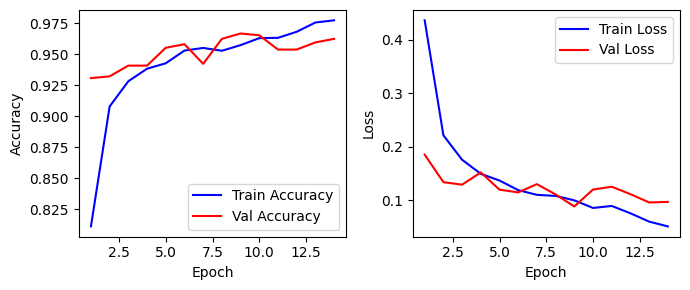

In [13]:
acc2 = history_tuned_cnn_rnn.history['accuracy']
val_acc = history_tuned_cnn_rnn.history['val_accuracy']
loss2 = history_tuned_cnn_rnn.history['loss']
val_loss = history_tuned_cnn_rnn.history['val_loss']
epochs = range(1, len(acc2) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 362ms/step - accuracy: 0.9535 - loss: 0.1083
Tuned CNN_RNN Test Accuracy: 0.9605
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step
Tuned CNN_RNN Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       548
   PNEUMONIA       0.98      0.95      0.96       427
TUBERCULOSIS       0.96      0.98      0.97       417

    accuracy                           0.96      1392
   macro avg       0.96      0.96      0.96      1392
weighted avg       0.96      0.96      0.96      1392



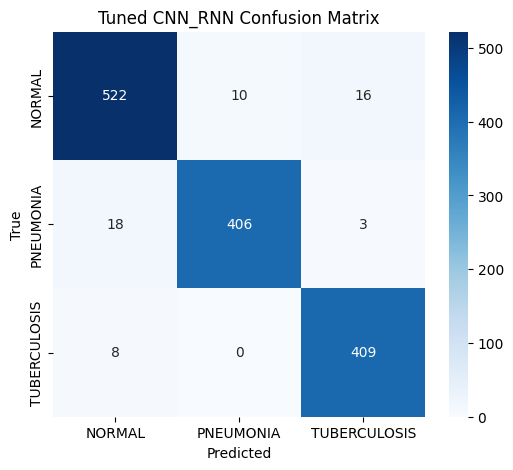

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate Tuned CNN
cnn_rnn_test_loss, cnn_rnn_test_acc = best_cnn_rnn_model.evaluate(test_gen)
print(f"Tuned CNN_RNN Test Accuracy: {cnn_rnn_test_acc:.4f}")

y_true = test_gen.classes
y_pred_cnn_rnn = np.argmax(best_cnn_rnn_model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("Tuned CNN_RNN Classification Report:")
print(classification_report(y_true, y_pred_cnn_rnn, target_names=class_labels))

cm_cnn_rnn = confusion_matrix(y_true, y_pred_cnn_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Tuned CNN_RNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Model Building (DNN)

In [16]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# base_dnn = Sequential([
#     Flatten(input_shape=(128, 128, 1)),

#     Dense(1024, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.3),  

#     Dense(512, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.3),

#     Dense(256, activation='relu', kernel_initializer='he_normal'),
    
#     Dense(3, activation='softmax')
# ])

# base_dnn.compile(
#     optimizer=Adam(0.0005),  
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history_dnn = base_dnn.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=15,
#     class_weight=class_weights  
# )

# base_dnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 181s 478ms/step - accuracy: 0.5688 - loss: 2.0374 - val_accuracy: 0.7680 - val_loss: 0.5123
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 167s 450ms/step - accuracy: 0.7246 - loss: 0.6237 - val_accuracy: 0.8602 - val_loss: 0.3714
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 167s 449ms/step - accuracy: 0.7547 - loss: 0.5685 - val_accuracy: 0.8401 - val_loss: 0.3796
Epoch 4/10
 21/372 ━━━━━━━━━━━━━━━━━━━━ 2:11 376ms/step - accuracy: 0.7886 - loss: 0.5221

KeyboardInterrupt: 

In [ ]:
# acc2 = history_dnn.history['accuracy']
# val_acc = history_dnn.history['val_accuracy']
# loss2 = history_dnn.history['loss']
# val_loss = history_dnn.history['val_loss']
# epochs = range(1, len(acc2) + 1)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
# axes[0].plot(epochs, val_acc, 'r', label='Val Accuracy')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Accuracy')
# axes[0].legend()

# axes[1].plot(epochs, loss2, 'b', label='Train Loss')
# axes[1].plot(epochs, val_loss, 'r', label='Val Loss')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Loss')
# axes[1].legend()

# plt.tight_layout()
# plt.show()


In [ ]:
# # Evaluate DNN
# test_loss_dnn, test_acc_dnn = base_dnn.evaluate(test_gen)
# print(f"DNN Test Accuracy: {test_acc_dnn:.4f}")

# y_pred_dnn = np.argmax(base_dnn.predict(test_gen), axis=1)

# print("Classification Report (DNN):")
# print(classification_report(y_true, y_pred_dnn, target_names=class_labels))

# cm_dnn = confusion_matrix(y_true, y_pred_dnn)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
# plt.title("Confusion Matrix (DNN)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()


# Hyperparameter Tuning (DNN)

### DNN

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam, RMSprop
# import keras_tuner as kt

# # ─── Custom Tuner to enable batch_size tuning 
# class DNNCustomTuner(kt.RandomSearch):
#     def run_trial(self, trial, *args, **kwargs):
#         hp = trial.hyperparameters
#         kwargs['batch_size'] = hp.get('batch_size')
#         return super().run_trial(trial, *args, **kwargs)

# # ─── Tunable DNN model function 
# def build_tuned_dnn(hp):
#     hp.Choice('batch_size', [32, 64, 128])
    
#     model = Sequential()
#     model.add(Flatten(input_shape=(128, 128, 1)))

#     # Tunable Dense layers
#     model.add(Dense(
#         units=hp.Choice('dense1', [512, 768, 1024]),
#         activation='relu',
#         kernel_initializer='he_normal'))

#     model.add(Dropout(hp.Float('dropout1', 0.2, 0.4, step=0.1)))

#     model.add(Dense(
#         units=hp.Choice('dense2', [256, 384, 512]),
#         activation='relu',
#         kernel_initializer='he_normal'))

#     model.add(Dropout(hp.Float('dropout2', 0.2, 0.4, step=0.1)))

#     model.add(Dense(
#         units=hp.Choice('dense3', [128, 256]),
#         activation='relu',
#         kernel_initializer='he_normal'))

#     model.add(Dense(3, activation='softmax'))

#     # Optimizer
#     optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
#     learning_rate = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')

#     if optimizer_choice == 'adam':
#         optimizer = Adam(learning_rate=learning_rate)
#     else:
#         optimizer = RMSprop(learning_rate=learning_rate)

#     model.compile(
#         optimizer=optimizer,
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model


In [ ]:
# # ─── Initialize tuner 
# dnn_tuner = DNNCustomTuner(
#     hypermodel=build_tuned_dnn,
#     objective='val_accuracy',
#     max_trials=8,
#     executions_per_trial=1,
#     directory='dnn_tuning_dir',
#     project_name='dnn_tuning',
#     overwrite=True
# )

# # ─── Start tuning 
# dnn_tuner.search(
#     train_gen,
#     validation_data=val_gen,
#     epochs=10,
#     callbacks=[
#         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#     ]
# )



In [ ]:
# # Get best hyperparameters
# best_hps_dnn = dnn_tuner.get_best_hyperparameters(1)[0]

# # Print best configuration
# print("\nBest Hyperparameters (DNN):")
# for param in best_hps_dnn.values.keys():
#     print(f"{param}: {best_hps_dnn.get(param)}")

# # Rebuild and train model from scratch using best hyperparams
# best_dnn_model = build_tuned_dnn(best_hps_dnn)
# batch_size_dnn = best_hps_dnn.get('batch_size')

# history_dnn = best_dnn_model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=15,
#     batch_size=batch_size_dnn,
#     class_weight=class_weights,
#     callbacks=[
#         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#     ]
# )


In [ ]:
# acc2 = history_tuned_dnn.history['accuracy']
# val_acc = history_tuned_dnn.history['val_accuracy']
# loss2 = history_tuned_dnn.history['loss']
# val_loss = history_tuned_dnn.history['val_loss']
# epochs = range(1, len(acc2) + 1)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
# axes[0].plot(epochs, val_acc, 'r', label='Val Accuracy')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Accuracy')
# axes[0].legend()

# axes[1].plot(epochs, loss2, 'b', label='Train Loss')
# axes[1].plot(epochs, val_loss, 'r', label='Val Loss')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Loss')
# axes[1].legend()

# plt.tight_layout()
# plt.show()


In [ ]:
# acc2 = history_tuned_dnn.history['accuracy']
# val_acc = history_tuned_dnn.history['val_accuracy']
# loss2 = history_tuned_dnn.history['loss']
# val_loss = history_tuned_dnn.history['val_loss']
# epochs = range(1, len(acc2) + 1)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
# axes[0].plot(epochs, val_acc, 'r', label='Val Accuracy')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Accuracy')
# axes[0].legend()

# axes[1].plot(epochs, loss2, 'b', label='Train Loss')
# axes[1].plot(epochs, val_loss, 'r', label='Val Loss')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Loss')
# axes[1].legend()

# plt.tight_layout()
# plt.show()


In [ ]:
# # Evaluate Tuned DNN
# dnn_test_loss, dnn_test_acc = best_dnn_model.evaluate(test_gen)
# print(f"Tuned DNN Test Accuracy: {dnn_test_acc:.4f}")

# y_pred_dnn = np.argmax(best_dnn_model.predict(test_gen), axis=1)

# print("Tuned DNN Classification Report:")
# print(classification_report(y_true, y_pred_dnn, target_names=class_labels))

# cm_dnn = confusion_matrix(y_true, y_pred_dnn)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
# plt.title("Tuned DNN Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()